In [1]:
import scipy.ndimage
from scipy.ndimage import gaussian_filter as blur

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mnist = input_data.read_data_sets('./data', one_hot=True)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [3]:
print(len(mnist.test.images))

10000


In [4]:
import matplotlib.pyplot as plt

(784,)
1.0


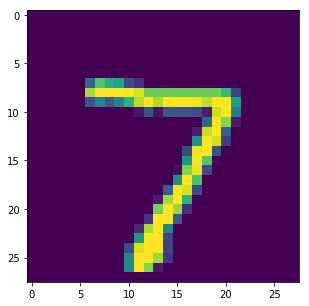

In [5]:
import numpy as np
print(mnist.test.images[0].shape)
print(np.max(mnist.test.images[0]))
plt.figure(figsize=(5, 5))
plt.imshow(mnist.test.images[0].reshape((28, 28)))
plt.show()

In [14]:
from random import randint

def place(img, im_size=0.5, frame_size=128):
    img = img.reshape((28, 28))
    img = cv2.resize(img, (0,0), fx=im_size, fy=im_size)
    ry, rx = randint(0, frame_size-img.shape[0]-1), randint(0, frame_size-img.shape[0]-1)
    return img, (rx, ry)
    

In [15]:
img, (rx, ry) = place(mnist.test.images[0])

### What advantages does temporal-aware model give us?

* Some tracking past occlusion
* Less confusion between background-foreground
* Awareness of likeliness given previous locations

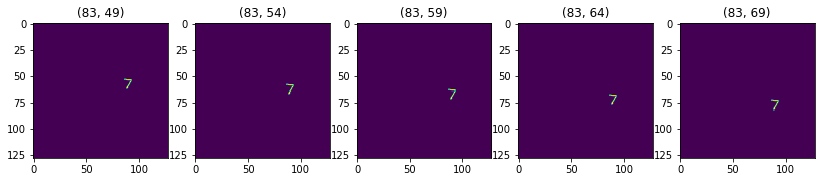

In [16]:
def get_direction():
    dirs = [(-1, -1), (-1, 1), (1, -1), (1, 1), (1, 0), (0, 1), (-1, 0), (0, -1)]
    return dirs[randint(0, len(dirs)-1)]

def animate(initial, steps=10, speed=5, size=128):
    img, (x0, y0) = initial
    ih, iw = img.shape
    coords = [(x0, y0)]
    
    rx, ry = get_direction()
    
    bg = np.zeros((size, size))
    bg[y0:y0+ih, x0:x0+iw] = img
    
    frames = [bg]
    for ii in range(steps):
        dy, dx = ry* speed, rx* speed

        # redirect if OOB:
        while bg[y0+dy:y0+dy+ih, x0+dx:x0+dx+iw].shape != (ih, iw):
            rx, ry = get_direction()
            dy, dx = ry* speed, rx* speed
        
        y0 += dy
        x0 += dx
        coords.append((x0, y0))
        bg = np.zeros((size, size))
        bg[y0:y0+ih, x0:x0+iw] = img
        frames.append(bg)
    return frames, coords
    
frames, coords = animate(place(mnist.test.images[0]), steps=10)

plt.figure(figsize=(14, 5))
for ii in range(5):
    plt.subplot(1, 5, ii+1)
    plt.gca().set_title('%s' % (coords[ii], ))
    plt.imshow(frames[ii])
plt.show()

In [17]:
frames, coords = animate(place(mnist.test.images[0]), steps=120)
print(len(frames))

121


In [18]:
import cv2
out = cv2.VideoWriter('mnist.avi', cv2.VideoWriter_fourcc(*'MJPG'), 30, (128, 128))
for frame in frames:
    disc = (frame*255).astype('uint8')
    clr = np.stack([disc, disc, disc], axis=2)
    out.write(clr)
out.release()

In [19]:
from IPython.core.display import display, HTML
# display(HTML('<h1>Hello, world!</h1>'))
HTML(' \
    <div align="left"> \
    <video width="25%" controls> \
          <source src="./mnist.avi" type="video/avi"> \
    </video></div> \
')

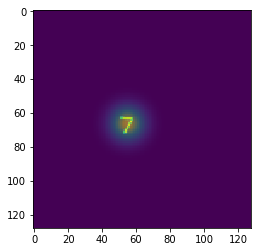

In [43]:
def matching_heatmap(coords, imsize=14, framesize=128):
    heats = []
    radius = int(imsize/2)
    for (xx, yy) in coords:
        bg = np.zeros((framesize, framesize))
        bg[yy+radius, xx+radius] = 255
        blurred = blur(bg, sigma=7)
        blurred /= np.max(blurred)
        heats.append((blurred * 255).astype(np.uint8))
    return heats

heats = matching_heatmap(coords)

plt.figure()
plt.imshow(frames[0])
# print(np.max(heats[0]))
plt.imshow(heats[0], alpha=0.5)
plt.show()

# for ii in range(100):
#     frames, coords = animate(place(mnist.test.images[ii]), steps=64)

In [57]:
import sys
for ii in range(100):
    sys.stdout.write('%d/100\r' % ii)
    sys.stdout.flush()
    out = cv2.VideoWriter('data/eval/%d_video.avi' % ii, cv2.VideoWriter_fourcc(*'MJPG'), 30, (128, 128))
    frames, coords = animate(place(mnist.test.images[ii]), steps=63)
    for frame in frames:
        disc = (frame*255).astype('uint8')
        clr = np.stack([disc, disc, disc], axis=2)
        out.write(clr)
    out.release()
    
    heats = matching_heatmap(coords)
    out = cv2.VideoWriter('data/eval/%d_heat.avi' % ii, cv2.VideoWriter_fourcc(*'MJPG'), 30, (128, 128))
    for frame in heats:
#         disc = (frame*255).astype('uint8')
        clr = np.stack([frame, frame, frame], axis=2)
        out.write(clr)
    out.release()
print()

99/100


In [56]:
HTML(' \
    <div style="width:300px;float:left"> \
    <video width="100%" controls> \
          <source src="data/eval/0_heat.avi" type="video/avi"> \
    </video></div> \
    <div style="width:300px;float:left"> \
    <video width="100%" controls> \
          <source src="data/eval/0_video.avi" type="video/avi"> \
    </video></div> \
')